# Relative Entropy in Gaussian networks
Ro Jefferson<br>
Last updated 2022-06-09

This notebook is designed to compute the relative entropy for networks generated by "Gaussian_Feedforward.ipynb". It reads in hdf5 data (weights, biases, and pre-activations) from a pre-trained network, and evaluates the relative entropy or Kullback-Leibler (KL) divergence as a function of depth. **The user must specify** the `PATH_TO_READ` and `PATH_TO_WRITE` below.

Take the reference distribution to be that of the pre-activations in layer $\ell$, denoted $p(z^\ell)=p^\ell$ where $z^\ell=\{z_0^\ell,\ldots,z_{n_\ell}^\ell\}$, and the approximate or model distribution to be that for layer $\ell+m$, denoted $q(z^{\ell+m})=q^{\ell+m}$. The KL divergence is then

\begin{equation}
D(p^\ell||q^{\ell+m})=\int\!\mathrm{d} z^\ell\,p(z^\ell)\ln\frac{p(z^\ell)}{q(z^{\ell+m})}
=\langle\ln p(z^\ell)\rangle_p-\langle q(z^{\ell+m})\rangle_p~.
\end{equation}

As detailed in the corresponding paper, this yields three terms:
\begin{equation}
D(p^\ell||q^{\ell+m})=-\frac{1}{2}\ln|2\pi e\Sigma_p|
+\frac{1}{2}\ln|2\pi\Sigma_q|
+\frac{1}{2}\left<Q^{\ell+m}\right>_p
\end{equation}

All of the difficulty stems from the third term, denoted by $Q$, which requires evaluating the expectation values of $z^{\ell+m}$ and $(z^{\ell+m})^2$ with respect to $p(z^\ell)$. Note that in practice, we shall fix the reference layer to $\ell=0$.

In [1]:
# Numpy, scipy, and plotting:
import numpy as np
from scipy.stats import norm         # Gaussian fitting
import scipy.integrate as integrate  # integration
import matplotlib.pyplot as plt      # plotting
import seaborn as sns; sns.set()     # nicer plotting
import pandas as pd                  # dataframe for use with seaborn

# File i/o:
import h5py    # HDF5

# Miscellaneous:
import math
import random     # random number generators
import re         # regular expressions
import gc         # garbage collection
import itertools  # generator slicing
import time       # for timing
import sys        # for printing progress

# symbolic algebra package:
import sympy as sym
from sympy import tanh

## Import hdf5 data
Specify the path to the .hdf5 files containing the accuracies, hooks, and parameters (weights & biases), and define functions to load and preprocess (i.e., sort) data:

In [2]:
PATH_TO_READ = '/full/path/to/Gaussian_Feedforward/data/'
PATH_TO_WRITE = '/full/path/to/write/directory/'

# read file of accuracies, return dataset as dictionary:
def read_accuracies(file_name):
    with h5py.File(PATH_TO_READ + file_name, 'r') as file:
        # cast elements as np.array, else returns closed file datasets:
        acc_dict = {key : np.array(file[key]) for key in file.keys()}  
        
    return acc_dict


# read file of inputs/outputs, return dataset as dictionary:
def read_hooks(file_name):    
    with h5py.File(PATH_TO_READ + file_name, 'r') as file:
        # cast elements as np.array, else returns closed file datasets:
        hook_dict = {key : np.array(file[key]) for key in file.keys()}
    
    return hook_dict


# given dictionary of hooks, extract list of preactivations:
def extract_preacts(hook_dict):
    keys = hook_dict.keys()
    
    layers, key_list = [], []
    for key in keys:
        if key.startswith('in'):
            key_list.append(key)
            layers.append(hook_dict[key][-1]) # use only last element
            
    # sort so that layers appear in correct order (for later analysis):
    layer_indices = [int(x.split('-')[1]) for x in key_list]
    sorted_layers = [lay for lay,_ in sorted(zip(layers, layer_indices), key = lambda x: x[1])]
    
    return sorted_layers


# read file of weights, biases; return dataset as dictionary:
def read_parameters(file_name):
    with h5py.File(PATH_TO_READ + file_name, 'r') as file:
        # cast elements as np.array, else returns closed file datasets:
        for key in file.keys():
            para_dict = {key : np.array(file[key]) for key in file.keys()}  
        
    return para_dict


# given dictionary of parameters, extract lists of weights, biases:
def extract_parameters(para_dict):
    keys = para_dict.keys()
    
    weights, W_keys = [], []
    biases, B_keys = [], []
    for key in keys:
        if key.startswith('W'):
            W_keys.append(key)
            weights.append(para_dict[key])
        elif key.startswith('B'):
            B_keys.append(key)
            biases.append(para_dict[key])

    # sort so that parameters appear in correct order (i.e., layer by layer):
    W_indices = [int(x.split('W')[1]) for x in W_keys]
    sorted_weights = [ww for ww,_ in sorted(zip(weights, W_indices), key = lambda x: x[1])]

    B_indices = [int(x.split('B')[1]) for x in B_keys]
    sorted_biases = [bb for bb,_ in sorted(zip(biases, B_indices), key = lambda x: x[1])]
    
    return sorted_weights, sorted_biases

    
# load data, ensuring consistent accuracies and hook files; return as dict:
def load_data(acc_file, hook_file, para_file):
    accuracies = read_accuracies(acc_file)
    hooks = read_hooks(hook_file)
    parameters = read_parameters(para_file)
    
    # get variances, depths; ensure consistency across files:
    var_w = [accuracies['var_weight'].item(), hooks['var_weight'].item(), parameters['var_weight'].item()]
    var_b = [accuracies['var_bias'].item(), hooks['var_bias'].item(), parameters['var_bias'].item()]
    depth = [accuracies['depth'].item(), hooks['depth'].item(), parameters['depth'].item()]
     # n.b., acc and para have key "depths" in older files; change to "depth" for new
    
    # check if all elements match the first:
    if not all([var_w[0] == v for v in var_w]):
        raise Exception('Error: mismatched weight variance in data files.\n')
    if not all([var_b[0] == v for v in var_b]):
        raise Exception('Error: mismatched bias variance in data files.\n')
    if not all([depth[0] == d for d in depth]):
        raise Exception('Error: mismatched depths in data files.\n')
     
    # extract and sort preactivations, parameters:
    preacts = extract_preacts(hooks)
    weights, biases = extract_parameters(parameters)
    widths = [x.shape[0] for x in preacts]  # get width of each layer
       
    # encapsulate data in dictionary (for compact return object):
    data = {'depth' : depth[0],
           'var_w' : var_w[0],
           'var_b' : var_b[0],
           'accuracies' : accuracies['accuracies'],
           'preacts' : preacts,
           'weights' : weights,
           'biases' : biases,
           'widths' : widths}
    
    # print relevant information about dataset and return:
    print('Successfully loaded data for network with depth {},'
          ' weight variance {}, bias variance {}\n'.format(depth[0], var_w[0], var_b[0]))
    #; architecture:\n'.format(depth[0], var_w[0], var_b[0]))
    #print('W = {}\nb = {}\n'.format([w.shape for w in weights], [b.shape for b in biases]))
    #print('keys: {}\n'.format(data.keys()))
    
    return data

Note the dimensions of each weight matrix: $|W^{\ell+1}|=(n,m)$ means $n$ rows, $m$ colums (where here $|\cdot|$ means dimension, not determinant)---$n$ rows corresponding to the neurons in the $\ell\!+\!1$ layer, and $m$ columns corresponding to the neurons in the $\ell$ layer. In other words, the *second* index of $W_{ij}$ runs over the neurons in the previous layer that connect to the neuron indexed by $i$. Element $W_{ij}^{\ell+1}$ is therefore the connection between $z_j^{\ell}$ and $z_i^{\ell+1}$. This is consistent with our notation for the connection rule, where we sum over the second index:

\begin{equation}
z_i^{\ell+1}=\sum_jW_{ij}^{\ell+1}\phi(z_j^\ell)+b_i^{\ell+1}~.
\end{equation}

## Recursive MC integral
The procedure implemented below is as follows. Let $m\!=\!0$ denote the reference layer. We begin at $m=1$ by drawing `nMC` Gaussian samples from the distribution with $\mu=\langle z^0\rangle$, $\sigma^2=\langle(z^0)^2\rangle-\langle z^0\rangle^2$, and use these to compute `nMC` samples of activations $\phi(z_i^0)$.

At $m=2$, we do the same, and use these to compute `nMC` samples of the *vector* of activations $\phi(z^1)=\{\phi(z_i^1)\}$. 

A key feature underlying the speed of this implementation is that once we have the entire vector, we do *not* recompute these at higher levels. Rather, at $m\!=\!3$, we simply multiply each element of this vector by the appropriate weight, and sum over $j$ to obtain `nMC` samples of $W_{ij}^2\phi(z_j^1)$. After adding the bias $b_i^2$, taking the $\tanh$, and repeating for all $i$, we obtain `nMC` samples of the vector $\phi(z^2)=\{\phi(z_i^2)\}=\{\tanh(W_{ij}^2\phi(z_j^1)+b_i^2)\}$. 

At each level, $\phi(z^m)$ can be immediately plugged into the MC integrator, which in this case simply computes the MC average over the samples; that is, for each $i$, $\int\mathcal{D}z_i^0\,\phi(z_i^m)=\frac{1}{N_\mathrm{MC}}\sum_{n=1}^{N_\mathrm{MC}}\phi(z_i^m)$. Similarly, to obtain $\int\mathcal{D}z_i^0\mathcal{D}z_j^0\,\phi(z_i^m)\phi(z_j^m)$, we simply plug-in all possible products over $i,j$, taking care not to mix different samples (because these are drawn from a Gaussian distribution, i.e., $\mathcal{D}z_i^0$ is a Gaussian measure over the reference pre-activations).

In [3]:
# return samples of phi(z_i^0):
def phi_sampler(layer, weights, preacts, num_samples=10**4, ref_layer=0):
    if layer != ref_layer:
        raise Exception('\nError: sample layer must equal ref_layer.\n')
        
    width = len(preacts[layer])
    dim = width*num_samples        # need num_samples of each neuron
    mean = np.mean(preacts[layer])
    std = np.std(preacts[layer])
    
    return np.reshape(np.tanh([random.gauss(mean, std) for _ in range(dim)]), (width, -1))


# compute phi(z^m) given phi(z^{m-1}):
def phi_new(m, phi, weights, biases):
    phiT = phi.transpose()  # each element now a single sample of the vector {phi(z_i^m)}

    phi_new = []
    for j in range(weights[m].shape[0]):
        samples = [np.tanh(np.sum(weights[m][j] * p_list) + biases[m][j]) for p_list in phiT]
        phi_new.append(samples)

    return np.array(phi_new)


# given 2d array phi with <width> rows and <nMC> columns, 
# compute MC integral of phi(z_i^m) and return list (index i):
def MC_int1(phi):
    nMC = phi.shape[1]
    return [np.sum(p)/nMC for p in phi]


# given 2d array phi with <width> rows and <nMC> columns, 
# compute MC integral of phi(z_i^m)*phi(z_j^m) and return list:
def MC_int2(phi):
    width = phi.shape[0]
    nMC = phi.shape[1]
    
    prod = []
    for j in range(width):
        for i in range(width):
            # element-wise multiplication (does not mix samples):
            prod.append(phi[i]*phi[j])

    return [np.sum(pp)/nMC for pp in prod]

## Expectation value of Q
We now have all the pieces required to compute the expectation value of $Q$.

In [4]:
def Q_term(mm, phi, weights, biases, preacts):
    # compute MC integrals:
    fj = MC_int1(phi)
    fjk = MC_int2(phi)

    # ----------------------- linear term: -----------------------
    bshift = biases[mm] - np.mean(preacts[mm])  # vector b^m - mu^m
    WT = weights[mm].transpose()                # invert rows/columns so each element has len(bshift)

    linear_term = []
    for j in range(len(fj)):
        linear_term.append(fj[j] * np.sum(WT[j] * bshift))  # sum over i

    linear_term = 2*np.sum(linear_term)

    # --------------------- quadratic term: ----------------------
    quadratic_term = []
    for j in range(len(fj)):
        for k in range(len(fj)):
            index = j*len(fj) + k

            sum_over_i = np.sum(WT[j] * WT[k])
            quadratic_term.append(fjk[index] * sum_over_i)

    quadratic_term = np.sum(quadratic_term)

    # ---------------------- constant term: ----------------------
    const_term = np.sum(bshift**2)
    
    return quadratic_term + linear_term + const_term

## Entropy functions
Finally, we'll create functions to handle the first two terms, namely entropy $\frac{1}{2}\ln|2\pi e\Sigma_p|$ and "almost-entropy" $\frac{1}{2}\ln|2\pi\Sigma_q|$. In the networks under study, the multivariate Gaussian of each layer factorizes into a product of single-variable Gaussians (one for each neuron), so

\begin{equation}
\frac{1}{2}\ln|2\pi e\Sigma_p|
=\frac{N_p}{2}\ln 2\pi e\sigma_p^2~,
\quad\mathrm{and}\quad
\frac{1}{2}\ln|2\pi\Sigma_q|
=\frac{N_q}{2}\ln 2\pi\sigma_q^2~,
\end{equation}

where $N_p$ arises from the taking the determinant of the $N_p\times N_p$ covariance matrix $\Sigma_p=\mathrm{diag}(\sigma_p^2,\ldots,\sigma_p^2)$, where $\sigma_p$ is the standard deviation of the layer (as per the large-N assumption); note that $N_p$ is the width of the corresponding layer, i.e., $N_p=|z^\ell|$. Similarly for $N_q$.

In [5]:
# Take in layer as array, return entropy:
def entropy(layer):
    var = np.std(layer)**2    # variance
    dim = layer.shape[0]      # dimension = layer width
    
    return math.log(2*math.pi*math.exp(1)*var)*(dim/2)


# Take in layer as array, return entropy minus N/2
# (i.e., almost entropy, without the factor of e):
def entropy_q(layer):
    return entropy(layer) - layer.shape[0]/2

Putting it all together, we'll have a single function that encapsulates the computation of relative entropy between the reference and target layers:

In [6]:
# a little function to monitor progress:
def progress(m,M):
    sys.stdout.write('\r')
    sys.stdout.write('Computing layer {} of {}...'.format(m,M))
    sys.stdout.flush()

In [7]:
# compute KL divergence for each layer, relative to ref_layer:
def KL_divergence(weights, biases, preacts, num_samples=10**4, ref_layer=0):
    start = time.time()  # timing
        
    term1 = -1*entropy(preacts[ref_layer])  
    
    term2, term3 = [], []  
    for m in range(ref_layer, len(preacts)):
        progress(m, len(preacts))  # monitor progress
            
        term2.append(entropy_q(preacts[m]))
        
        # get samples of phi(z^{m-1}):
        if m == ref_layer:
            term3.append(preacts[m].shape[0]/2)  # p=q implies Q=N/2     
        else:
            # m = ref+1, generate MC samples for innermost tanh:
            if m == ref_layer+1:  
                phi = phi_sampler(m-1, weights, preacts, num_samples, ref_layer)
            # m > ref+1, use previous layer's tanh instead of recursion:
            else:                   
                phi = phi_new(m-1, phi, weights, biases)
        
            # compute Q term, include factor of 1/(2*sig^2):
            cov_q = np.std(preacts[m])**2
            term3.append(Q_term(m, phi, weights, biases, preacts)/(2*cov_q))
    
    # add contributions at each layer:
    result = [term1+term2+term3 for term2,term3 in zip(term2,term3)]

    # print timing, result:
    end = time.time()
    print('\rResult = {}\n\nComputation took {} seconds\n'.format(result, end-start))
    
    return result

# Runtime

Let's create some functions to write the results, as well as to handle scanning through data files and running the KL analysis:

In [8]:
# write file of KL divergences:
def write_KL(file_name, KL_list, var_weight, var_bias, width_list):
    with h5py.File(PATH_TO_WRITE + file_name, 'w') as file:
        file.create_dataset('var_weight', data=var_weight)
        file.create_dataset('var_bias', data=var_bias)
        file.create_dataset('depth', data=len(KL_list))
        file.create_dataset('KL', data=KL_list)
        file.create_dataset('widths', data=width_list)

        
# corresponding read file, while we're at it:
def read_KL(path, file_name):
    with h5py.File(path + file_name, 'r') as file:
        # cast elements as np.array, else returns closed file datasets:
        KL_dict = {key : np.array(file[key]) for key in file.keys()}  
        
    return KL_dict

Standalone example:

In [9]:
nMC = 10**1  # number of MC samples
results = {}   # dict to store results
data = load_data('acc-20-10.hdf5', 'e0-hooks-20-10.hdf5', 'e0-para-20-10.hdf5')
results['pre20'] = KL_divergence(data['weights'], data['biases'], data['preacts'], nMC)

write_KL('KL-20-pre.hdf5', results['pre20'], data['var_w'], data['var_b'], data['widths'])

Successfully loaded data for network with depth 10, weight variance 2.0, bias variance 0.05

Result = [0.0, 162.13237006509405, 262.4943490025445, 309.8128892665676, 337.921695677118, 334.25225108342755, 364.82280534031656, 363.19949917521825, -109.14905126288991, -602.7513251872606]

Computation took 71.75646376609802 seconds



Since we're typically interested in processing a sequence of models with fixed depth but different weight variances, let's write a method to automate this:

In [10]:
def load_and_run(depth, epochs, min_var, max_var, step_var, num_samples):
    # check for invalid filename parameters:
    if depth < 0 or not isinstance(depth, int):
        raise Exception('Error: depth must be positive integer.\n')
    if min_var > max_var or min_var < 0 or step_var < 0 or not isinstance(min_var, int) or not isinstance(max_var, int) or not isinstance(step_var, int):
        raise Exception('Error: invalid variance range.\n')
    if num_samples < 0 or not isinstance(num_samples, int): 
        raise Exception('Error: num_samples must be positive integer.\n')
    
    # get prefix from number of epochs (i.e., check if pre- vs. post-training dataset):
    if epochs == 0 and isinstance(epochs, int):
        pre_or_post = '-pre'
        prefix = 'e0-'
    elif epochs > 0 and isinstance(epochs, int):
        pre_or_post = '-post'
        prefix = 'e{}-'.format(epochs)
    else:
        raise Exception('Error: number of epochs must be non-negative integer.\n')
    
    # generate filename indices in specified variance range for fixed depth:
    file_index = ['{}-{}'.format(var, depth) for var in range(min_var, max_var, step_var)]
    
    for i in range(len(file_index)):
        # load hdf5 files:
        acc_file = 'acc-' + file_index[i] + '.hdf5'
        hook_file = prefix + 'hooks-' + file_index[i] + '.hdf5'
        para_file = prefix + 'para-' + file_index[i] + '.hdf5'    
        data = load_data(acc_file, hook_file, para_file)
        
        # compute KL divergence:
        result = KL_divergence(data['weights'], data['biases'], data['preacts'], num_samples)

        # write results:
        KL_file = 'KL-' + file_index[i] + pre_or_post + '.hdf5'
        write_KL(KL_file, result, data['var_w'], data['var_b'], data['widths'])

In [11]:
# epoch 0, untrained:
load_and_run(30, 0, 100, 351, 50, 10**3)

Successfully loaded data for network with depth 30, weight variance 1.0, bias variance 0.05

Result = [0.0, 74.66171313381295, 94.83278400210503, 113.31871946714216, 102.28094870814141, 83.11410043105309, 104.07303193844967, 130.6183649297173, 118.64862623648929, 110.18212991217888, 120.14285835761689, 117.76293737571547, 79.72570495004538, 63.81198268574303, 38.485416631989835, 42.50885264620359, 67.54689158858815, 48.3107201588856, 62.84828588968696, 66.20776366921814, 94.27946229482029, 90.68829297086103, 104.6230971713506, 109.65388974575836, 100.09789267011939, 81.70393263390173, 91.22707477196258, 91.93985031417714, -99.73256654010771, -324.45087501069924]

Computation took 688.8092570304871 seconds

Successfully loaded data for network with depth 30, weight variance 1.5, bias variance 0.05

Result = [0.0, 169.06597075673028, 257.9719543361746, 295.8963743594737, 309.4855560095384, 327.53540121671267, 338.3604700687041, 364.80110371828516, 350.10533860345197, 347.13041689132484, 

In [12]:
# epoch 14, trained:
load_and_run(30, 14, 100, 351, 50, 10**3)

Successfully loaded data for network with depth 30, weight variance 1.0, bias variance 0.05

Result = [0.0, 104.16680291165306, 100.47227605810104, 87.91157828369063, 82.65877310598688, 115.03022048548539, 149.44371278785604, 209.2580863524091, 220.89170208958296, 233.53132002398115, 211.25961837446027, 235.79847789282493, 247.59874900577483, 240.4479258809233, 270.01639081953283, 290.41410667383684, 307.6168008454738, 335.14024126267645, 343.9667892779769, 349.54920907739853, 375.88106031953896, 379.08054422403757, 391.08829293285635, 413.6401275218377, 437.2499219698788, 454.0191235313807, 491.04687818238494, 532.2396935422692, 244.90693975417247, -248.92747651070567]

Computation took 549.4993879795074 seconds

Successfully loaded data for network with depth 30, weight variance 1.5, bias variance 0.05

Result = [0.0, 189.48131917436706, 274.11199470933633, 304.6730426533626, 323.8930561763605, 353.22273811866967, 372.1400551029024, 409.68148948216617, 396.9144170480731, 390.55605289

# Plot results

In [13]:
# compare pre- vs. post-training KL; assume same depth, width (of reference layer),
#    var_b, and var_w between file lists:
def pre_post_compare(depth, base1, base2, start, stop, step, plot=True, write=False):
    # file names in format KL-{var}-{base}.hdf5
    filenames1 = ['KL-{}-{}-{}.hdf5'.format(var, depth, base1) for var in range(start, stop, step)]
    filenames2 = ['KL-{}-{}-{}.hdf5'.format(var, depth, base2) for var in range(start, stop, step)]
    
    if len(filenames1) != len(filenames2):
        raise Exception('Error: mismatched file lists.\n')
    
    rel_ent1, rel_ent2, depth, var_w, var_b = [], [], [], [], []
    for i in range(len(filenames1)):
        # load data:
        data1 = read_KL(PATH_TO_WRITE, filenames1[i])
        data2 = read_KL(PATH_TO_WRITE, filenames2[i])

        # truncate & renormalize rel_ent by entropy of reference layer:        
        var = data1['var_weight'].item()
        width = data1['widths'][0]
        rel_ent_norm1 = data1['KL'][:-2]/(width*np.log(2*np.pi*np.e*var)/2)
        rel_ent_norm2 = data2['KL'][:-2]/(width*np.log(2*np.pi*np.e*var)/2)
        
        rel_ent1.append(rel_ent_norm1)
        rel_ent2.append(rel_ent_norm2)
        
        depth.append(data1['depth'].item())
        var_w.append(var)
        var_b.append(data1['var_bias'].item())
    
    if plot:   
        plt.rcParams['figure.figsize'] = [9, 6]   # globally (!) adjust figure size 

        # plot first series, labelled by variance:
        list_dict = {r'$\sigma_w^2$ = {}'.format(vv) : pd.Series(rel_ent1[i])
                     for i,vv in enumerate(var_w)}
        df = pd.DataFrame(list_dict)
        KL_plot = df.plot()
        
        # get colors of lines, so can use same scheme in second plot:
        lines = KL_plot.get_lines()
        colors = [line.get_color() for line in lines]
        # add alpha parameter, to make transluscent:
        colors = [(c[0], c[1], c[2], 0.5) for c in colors]
        
        # plot second series on top of same graph:
        list_dict2 = {'var_w = {}'.format(vv) : pd.Series(rel_ent2[i])
             for i,vv in enumerate(var_w)}
        styles=['--']*len(filenames2)
        df2 = pd.DataFrame(list_dict2)
        # overlay plots:
        KL_plot = df2.plot(ax=KL_plot, style=styles, color=colors, legend=None)  # use same colors as before!
    
        # format title, axes:
        KL_plot.set_title('KL divergence vs. depth') 
        KL_plot.set_xlabel('layer')
        KL_plot.set_ylabel('KL divergence')
        
        # optionally save plot as pdf:
        if write:
            plt.savefig(PATH_TO_WRITE + 'plot-compare.pdf')

    return rel_ent1, rel_ent2, depth, var_w, var_b
        

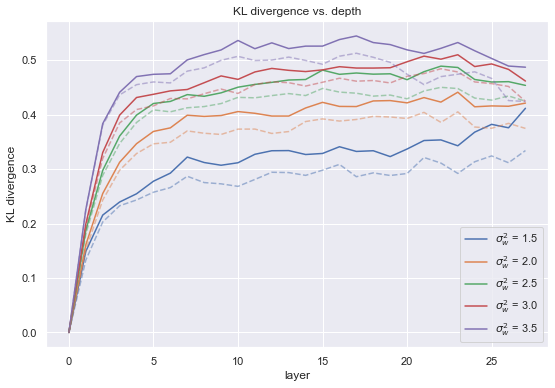

In [14]:
kl1, kl2, dep, var_w, var_b = pre_post_compare(30, 'post', 'pre', 150, 351, 50, True, False);

Out of curiousity, plot corresponding accuracies:

In [15]:
# read file of accuracies, return dataset as dictionary:
def read_accuracies(file_name):
    with h5py.File(PATH_TO_READ + file_name, 'r') as file:
        # cast elements as np.array, else returns closed file datasets:
        acc_dict = {key : np.array(file[key]) for key in file.keys()}  
        
    return acc_dict

In [16]:
# automatically read and plot accuracies; format 'acc-var-base.hdf5':
def read_and_plot_accs(base, start, stop, step, plot=True, write=False):
    # file names in format acc-{var}-{base}.hdf5
    filenames = ['acc-{}-{}.hdf5'.format(var, base) for var in range(start, stop, step)]
    
    print('Reading {} files: {}\n'.format(len(filenames), filenames))
    
    acc_list, var_list = [], []
    for i in range(len(filenames)):
        # load data:
        data = read_accuracies(filenames[i])

        # extract variance, accuracies:
        var_list.append(data['var_weight'].item())
        acc_list.append(data['accuracies'])
    
    # get (assumed all same) var_b, depth from last file:
    var_b = data['var_bias'].item()
    depth = data['depth'].item()
    
    if plot:   
        #plt.rcParams['figure.figsize'] = [9, 6]   # globally (!) adjust figure size 
        
        # plot each series, labelled by depth:
        list_dict = {'var_w = {}'.format(vv) : pd.Series(acc_list[i])
                     for i,vv in enumerate(var_list)}
        df = pd.DataFrame(list_dict)
        KL_plot = df.plot()
        KL_plot.set_title('Depth = {}, var_b = {}'.format(depth, var_b)) 
        
        # optionally save plot as pdf:
        if write:
            plt.savefig(PATH_TO_WRITE + 'plot-{}.pdf'.format(base))

    return acc_list, var_list

Reading 5 files: ['acc-150-30.hdf5', 'acc-200-30.hdf5', 'acc-250-30.hdf5', 'acc-300-30.hdf5', 'acc-350-30.hdf5']



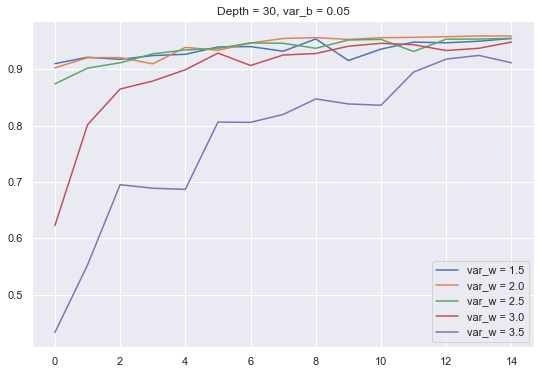

In [17]:
read_and_plot_accs(30, 150, 351, 50, True, False);